In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
#sequence_2018_05_07-19.06.27.csv
df = pd.read_csv("sequences/sequence_2018_05_03-16.54.37.csv")
df.head()

,attr_1,attr_2,attr_3,attr_4
0,2.0,4.0,1.0,1.0
1,2.0,1.0,1.0,1.0
2,3.0,4.0,1.0,5.0
3,2.0,4.0,1.0,1.0
4,2.0,4.0,1.0,1.0


In [4]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['attr_1'] = min_max_scaler.fit_transform(df.attr_1.values.reshape(-1,1))
    df['attr_2'] = min_max_scaler.fit_transform(df.attr_2.values.reshape(-1,1))
    df['attr_3'] = min_max_scaler.fit_transform(df.attr_3.values.reshape(-1,1))
    df['attr_4'] = min_max_scaler.fit_transform(df.attr_4.values.reshape(-1,1))    
    return df
df = normalize_data(df)
df.head()

,attr_1,attr_2,attr_3,attr_4
0,0.333333,0.75,0.0,0.0
1,0.333333,0.00,0.0,0.0
2,0.666667,0.75,0.0,0.8
3,0.333333,0.75,0.0,0.0
4,0.333333,0.75,0.0,0.0


In [10]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    result = np.array(result)
    row = round(0.75 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [11]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [12]:
window = 15
X_train, y_train, X_test, y_test = load_data(df, window)
print (X_train[0], y_train[0])

[[0.33333333 0.75       0.         0.        ]
 [0.33333333 0.         0.         0.        ]
 [0.66666667 0.75       0.         0.8       ]
 [0.33333333 0.75       0.         0.        ]
 [0.33333333 0.75       0.         0.        ]
 [0.33333333 0.75       0.         0.        ]
 [0.33333333 0.75       0.         0.        ]
 [0.66666667 0.75       0.         0.        ]
 [0.33333333 0.75       0.         0.        ]
 [0.33333333 0.75       0.         0.        ]
 [0.66666667 0.75       0.         0.        ]
 [0.33333333 0.75       0.         0.4       ]
 [0.33333333 0.75       0.         0.        ]
 [0.33333333 0.5        0.         0.        ]
 [0.33333333 0.75       0.         0.        ]] 0.0


In [13]:
model = build_model([4,window,1])

Compilation Time :  0.03162574768066406


In [14]:
model.fit(X_train,y_train,batch_size=512,epochs=20,validation_split=0.1,verbose=1)

Train on 9574 samples, validate on 1064 samples
Epoch 1/20
9574/9574 [==============================] - 47s 5ms/step - loss: 0.1598 - acc: 0.7033 - val_loss: 0.0614 - val_acc: 0.8947
Epoch 2/20
9574/9574 [==============================] - 44s 5ms/step - loss: 0.0514 - acc: 0.8283 - val_loss: 0.0450 - val_acc: 0.9060
Epoch 3/20
9574/9574 [==============================] - 46s 5ms/step - loss: 0.0456 - acc: 0.8285 - val_loss: 0.0451 - val_acc: 0.9051
Epoch 4/20
9574/9574 [==============================] - 49s 5ms/step - loss: 0.0434 - acc: 0.8286 - val_loss: 0.0462 - val_acc: 0.9060
Epoch 5/20
9574/9574 [==============================] - 46s 5ms/step - loss: 0.0426 - acc: 0.8292 - val_loss: 0.0442 - val_acc: 0.9070
Epoch 6/20
9574/9574 [==============================] - 49s 5ms/step - loss: 0.0425 - acc: 0.8296 - val_loss: 0.0437 - val_acc: 0.9070
Epoch 7/20
9574/9574 [==============================] - 68s 7ms/step - loss: 0.0417 - acc: 0.8297 - val_loss: 0.0441 - val_acc: 0.9070
Epoch 8

In [15]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
print (p.shape)
# for each data index in test data
for u in range(len(y_test)):
    # pr = prediction day u
    pr = p[u][0]
    # (y_test day u / pr) - 1
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    # print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))
    # Last day prediction
    # print(p[-1]) 

(3546, 1)


In [17]:
df = pd.read_csv("sequences/sequence_2018_05_03-16.54.37.csv")

def denormalize(df, normalized_value): 
    df = df['attr_4'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(df, p)
newy_test = denormalize(df, y_test)

In [18]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.04250 MSE (0.21 RMSE)
Test Score: 0.03909 MSE (0.20 RMSE)


(0.04250310064382917, 0.03908782192856258)

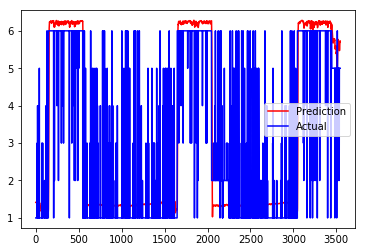

In [19]:
import matplotlib.pyplot as plt2

plt2.plot(newp,color='red', label='Prediction')
plt2.plot(newy_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()

In [ ]:
print(len(y_test), len(y_train))

In [20]:
import sys
sys.path.append('./detectors/')
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from scipy import signal
from online_simulator import OnlineSimulator
from rules_detector import RulesDetector
from utils import *
from zscore_detector import ZScoreDetector

In [21]:
df = pd.read_csv('sequences/sequence_2018_05_03-16.54.37.csv')
# df = pd.read_csv('sequences/sequence_2018_07_21-22.24.18.csv')
seq_names = ['attr_1', 'attr_4']

predict_ratio=0.75
base_seqs =[]

for name in seq_names:
    base_seqs.append(np.array(df[name]))

sequences = [[] for i in range(len(base_seqs))]
for nr in range(1):
    for i, seq in enumerate(sequences):
        sequences[i] = np.concatenate((seq, base_seqs[i]))

In [22]:
win_size = 20
detector1 = ZScoreDetector(window_size=30, threshold=5)
detector2 = ZScoreDetector(window_size=win_size, threshold=4)
detector3 = ZScoreDetector(window_size=win_size, threshold=4)
detector4 = ZScoreDetector(window_size=win_size, threshold=4)

rules_detector = RulesDetector(target_seq_index=1,
                               window_size=0,
                               round_to=100,
                               type="all",
                               combined=False)

simulator = OnlineSimulator(rules_detector,
                            [detector1, detector4],
                            sequences,
                            seq_names,
                            predict_ratio=predict_ratio)

./detectors/zscore_detector.py:65: RuntimeWarning: invalid value encountered in double_scalars
  self.std_diff = (g_std - w_std) / g_std
./detectors/zscore_detector.py:69: RuntimeWarning: invalid value encountered in double_scalars
  self.z_score_ = (w_mean - g_mean_) / self.SE


curr_index: 10650
first_pred: True
seq_index == self.rules_detector.target_seq_index: False
detector.is_change_detected is True: False
curr_index: 10650
first_pred: True
seq_index == self.rules_detector.target_seq_index: True
detector.is_change_detected is True: False
curr_index: 10651
first_pred: True
seq_index == self.rules_detector.target_seq_index: False
detector.is_change_detected is True: False
curr_index: 10651
first_pred: True
seq_index == self.rules_detector.target_seq_index: True
detector.is_change_detected is True: False
curr_index: 10652
first_pred: True
seq_index == self.rules_detector.target_seq_index: False
detector.is_change_detected is True: False
curr_index: 10652
first_pred: True
seq_index == self.rules_detector.target_seq_index: True
detector.is_change_detected is True: False
curr_index: 10653
first_pred: True
seq_index == self.rules_detector.target_seq_index: False
detector.is_change_detected is True: False
curr_index: 10653
first_pred: True
seq_index == self.rules

detector.is_change_detected is True: False
curr_index: 10706
first_pred: True
seq_index == self.rules_detector.target_seq_index: True
detector.is_change_detected is True: False
curr_index: 10707
first_pred: True
seq_index == self.rules_detector.target_seq_index: False
detector.is_change_detected is True: False
curr_index: 10707
first_pred: True
seq_index == self.rules_detector.target_seq_index: True
detector.is_change_detected is True: False
curr_index: 10708
first_pred: True
seq_index == self.rules_detector.target_seq_index: False
detector.is_change_detected is True: False
curr_index: 10708
first_pred: True
seq_index == self.rules_detector.target_seq_index: True
detector.is_change_detected is True: False
curr_index: 10709
first_pred: True
seq_index == self.rules_detector.target_seq_index: False
detector.is_change_detected is True: False
curr_index: 10709
first_pred: True
seq_index == self.rules_detector.target_seq_index: True
detector.is_change_detected is True: False
curr_index: 1071

curr_index: 10778
first_pred: True
seq_index == self.rules_detector.target_seq_index: True
detector.is_change_detected is True: False
curr_index: 10779
first_pred: True
seq_index == self.rules_detector.target_seq_index: False
detector.is_change_detected is True: False
curr_index: 10779
first_pred: True
seq_index == self.rules_detector.target_seq_index: True
detector.is_change_detected is True: False
curr_index: 10780
first_pred: True
seq_index == self.rules_detector.target_seq_index: False
detector.is_change_detected is True: False
curr_index: 10780
first_pred: True
seq_index == self.rules_detector.target_seq_index: True
detector.is_change_detected is True: False
curr_index: 10781
first_pred: True
seq_index == self.rules_detector.target_seq_index: False
detector.is_change_detected is True: False
curr_index: 10781
first_pred: True
seq_index == self.rules_detector.target_seq_index: True
detector.is_change_detected is True: False
curr_index: 10782
first_pred: True
seq_index == self.rules_

first_pred: False
curr_index: 10844
first_pred: False
curr_index: 10844
first_pred: False
curr_index: 10845
first_pred: False
curr_index: 10845
first_pred: False
curr_index: 10846
first_pred: False
curr_index: 10846
first_pred: False
curr_index: 10847
first_pred: False
curr_index: 10847
first_pred: False
curr_index: 10848
first_pred: False
curr_index: 10848
first_pred: False
curr_index: 10849
first_pred: False
curr_index: 10849
first_pred: False
curr_index: 10850
first_pred: False
curr_index: 10850
first_pred: False
curr_index: 10851
first_pred: False
curr_index: 10851
first_pred: False
curr_index: 10852
first_pred: False
curr_index: 10852
first_pred: False
curr_index: 10853
first_pred: False
curr_index: 10853
first_pred: False
curr_index: 10854
first_pred: False
curr_index: 10854
first_pred: False
curr_index: 10855
first_pred: False
curr_index: 10855
first_pred: False
curr_index: 10856
first_pred: False
curr_index: 10856
first_pred: False
curr_index: 10857
first_pred: False
curr_index

curr_index: 10972
first_pred: False
curr_index: 10972
first_pred: False
curr_index: 10973
first_pred: False
curr_index: 10973
first_pred: False
curr_index: 10974
first_pred: False
curr_index: 10974
first_pred: False
curr_index: 10975
first_pred: False
curr_index: 10975
first_pred: False
curr_index: 10976
first_pred: False
curr_index: 10976
first_pred: False
curr_index: 10977
first_pred: False
curr_index: 10977
first_pred: False
curr_index: 10978
first_pred: False
curr_index: 10978
first_pred: False
curr_index: 10979
first_pred: False
curr_index: 10979
first_pred: False
curr_index: 10980
first_pred: False
curr_index: 10980
first_pred: False
curr_index: 10981
first_pred: False
curr_index: 10981
first_pred: False
curr_index: 10982
first_pred: False
curr_index: 10982
first_pred: False
curr_index: 10983
first_pred: False
curr_index: 10983
first_pred: False
curr_index: 10984
first_pred: False
curr_index: 10984
first_pred: False
curr_index: 10985
first_pred: False
curr_index: 10985
first_pred

[attr_1(2.0){500; 86%}, attr_1(3.0){300; 91%}, attr_1(4.0){500; 91%}]
best_rule.get_rule_score(): 4200.0
self.predicted_rule.get_rule_score(): 4800.0
self.predicted_len <= curr_elem_index: False
curr_elem_index: 11100
self.predicted_rule.rhs.value: 6.0
predicting  6.0 for 100 next elems
[attr_4(1.0){800; 0%}] ==> attr_4(6.0){400; 93%}
	# rule_support:	4
	# lhs_support:	4
	# confidence:	1.0
	# rule_score:	4800.0
	# occurences:	[1208, 5504, 8404, 10003]
11100 11203
self.predicted_len: 11203
---END Predict sequence  seq_index: 0 curr_elem_index: 11100

curr_index: 11100
first_pred: False
curr_index: 11101
first_pred: False
curr_index: 11101
first_pred: False
curr_index: 11102
first_pred: False
curr_index: 11102
first_pred: False
curr_index: 11103
first_pred: False
curr_index: 11103
first_pred: False
curr_index: 11104
first_pred: False
curr_index: 11104
first_pred: False
curr_index: 11105
first_pred: False
curr_index: 11105
first_pred: False
curr_index: 11106
first_pred: False
curr_index: 

best_rule.get_rule_score(): 4200.0
self.predicted_rule.get_rule_score(): 4800.0
self.predicted_len <= curr_elem_index: False
curr_elem_index: 11200
self.predicted_rule.rhs.value: 6.0
predicting  6.0 for 100 next elems
[attr_4(1.0){800; 0%}] ==> attr_4(6.0){400; 93%}
	# rule_support:	4
	# lhs_support:	4
	# confidence:	1.0
	# rule_score:	4800.0
	# occurences:	[1208, 5504, 8404, 10003]
11200 11303
self.predicted_len: 11203
---END Predict sequence  seq_index: 0 curr_elem_index: 11200

curr_index: 11200
first_pred: False
curr_index: 11201
first_pred: False
curr_index: 11201
first_pred: False
curr_index: 11202
first_pred: False
curr_index: 11202
first_pred: False
curr_index: 11203
first_pred: False
curr_index: 11203
first_pred: False
curr_index: 11204
first_pred: False
curr_index: 11204
first_pred: False
curr_index: 11205
first_pred: False
curr_index: 11205
first_pred: False
curr_index: 11206
first_pred: False
curr_index: 11206
first_pred: False
curr_index: 11207
first_pred: False
curr_index

first_pred: False
curr_index: 11333
first_pred: False
curr_index: 11333
first_pred: False
curr_index: 11334
first_pred: False
curr_index: 11334
first_pred: False
curr_index: 11335
first_pred: False
curr_index: 11335
first_pred: False
curr_index: 11336
first_pred: False
curr_index: 11336
first_pred: False
curr_index: 11337
first_pred: False
curr_index: 11337
first_pred: False
curr_index: 11338
first_pred: False
curr_index: 11338
first_pred: False
curr_index: 11339
first_pred: False
curr_index: 11339
first_pred: False
curr_index: 11340
first_pred: False
curr_index: 11340
first_pred: False
curr_index: 11341
first_pred: False
curr_index: 11341
first_pred: False
curr_index: 11342
first_pred: False
curr_index: 11342
first_pred: False
curr_index: 11343
first_pred: False
curr_index: 11343
first_pred: False
curr_index: 11344
first_pred: False
curr_index: 11344
first_pred: False
curr_index: 11345
first_pred: False
curr_index: 11345
first_pred: False
curr_index: 11346
first_pred: False
curr_index

first_pred: False
curr_index: 11431
first_pred: False
curr_index: 11431
first_pred: False
curr_index: 11432
first_pred: False
curr_index: 11432
first_pred: False
curr_index: 11433
first_pred: False
curr_index: 11433
first_pred: False
curr_index: 11434
first_pred: False
curr_index: 11434
first_pred: False
curr_index: 11435
first_pred: False
curr_index: 11435
first_pred: False
curr_index: 11436
first_pred: False
curr_index: 11436
first_pred: False
curr_index: 11437
first_pred: False
curr_index: 11437
first_pred: False
curr_index: 11438
first_pred: False
curr_index: 11438
first_pred: False
curr_index: 11439
first_pred: False
curr_index: 11439
first_pred: False
curr_index: 11440
first_pred: False
curr_index: 11440
first_pred: False
curr_index: 11441
first_pred: False
curr_index: 11441
first_pred: False
curr_index: 11442
first_pred: False
curr_index: 11442
first_pred: False
curr_index: 11443
first_pred: False
curr_index: 11443
first_pred: False
curr_index: 11444
first_pred: False
curr_index

first_pred: False
curr_index: 11569
first_pred: False
curr_index: 11569
first_pred: False
curr_index: 11570
first_pred: False
curr_index: 11570
first_pred: False
curr_index: 11571
first_pred: False
curr_index: 11571
first_pred: False
curr_index: 11572
first_pred: False
curr_index: 11572
first_pred: False
curr_index: 11573
first_pred: False
curr_index: 11573
first_pred: False
curr_index: 11574
first_pred: False
curr_index: 11574
first_pred: False
curr_index: 11575
first_pred: False
curr_index: 11575
first_pred: False
curr_index: 11576
first_pred: False
curr_index: 11576
first_pred: False
curr_index: 11577
first_pred: False
curr_index: 11577
first_pred: False
curr_index: 11578
first_pred: False
curr_index: 11578
first_pred: False
curr_index: 11579
first_pred: False
curr_index: 11579
first_pred: False
curr_index: 11580
first_pred: False
curr_index: 11580
first_pred: False
curr_index: 11581
first_pred: False
curr_index: 11581
first_pred: False
curr_index: 11582
first_pred: False
curr_index

first_pred: False
curr_index: 11660
first_pred: False
curr_index: 11661
first_pred: False
curr_index: 11661
first_pred: False
curr_index: 11662
first_pred: False
curr_index: 11662
first_pred: False
curr_index: 11663
first_pred: False
curr_index: 11663
first_pred: False
curr_index: 11664
first_pred: False
curr_index: 11664
first_pred: False
curr_index: 11665
first_pred: False
curr_index: 11665
first_pred: False
curr_index: 11666
first_pred: False
curr_index: 11666
first_pred: False
curr_index: 11667
first_pred: False
curr_index: 11667
first_pred: False
curr_index: 11668
first_pred: False
curr_index: 11668
first_pred: False
curr_index: 11669
first_pred: False
curr_index: 11669
first_pred: False
curr_index: 11670
first_pred: False
curr_index: 11670
first_pred: False
curr_index: 11671
first_pred: False
curr_index: 11671
first_pred: False
curr_index: 11672
first_pred: False
curr_index: 11672
first_pred: False
curr_index: 11673
first_pred: False
curr_index: 11673
first_pred: False
curr_index

first_pred: False
curr_index: 11779
first_pred: False
curr_index: 11779
first_pred: False
curr_index: 11780
first_pred: False
curr_index: 11780
first_pred: False
curr_index: 11781
first_pred: False
curr_index: 11781
first_pred: False
curr_index: 11782
first_pred: False
curr_index: 11782
first_pred: False
curr_index: 11783
first_pred: False
curr_index: 11783
first_pred: False
curr_index: 11784
first_pred: False
curr_index: 11784
first_pred: False
curr_index: 11785
first_pred: False
curr_index: 11785
first_pred: False
curr_index: 11786
first_pred: False
curr_index: 11786
first_pred: False
curr_index: 11787
first_pred: False
curr_index: 11787
first_pred: False
curr_index: 11788
first_pred: False
curr_index: 11788
first_pred: False
curr_index: 11789
first_pred: False
curr_index: 11789
first_pred: False
curr_index: 11790
first_pred: False
curr_index: 11790
first_pred: False
curr_index: 11791
first_pred: False
curr_index: 11791
first_pred: False
curr_index: 11792
first_pred: False
curr_index

curr_index: 11882
first_pred: False
curr_index: 11882
first_pred: False
curr_index: 11883
first_pred: False
curr_index: 11883
first_pred: False
curr_index: 11884
first_pred: False
curr_index: 11884
first_pred: False
curr_index: 11885
first_pred: False
curr_index: 11885
first_pred: False
curr_index: 11886
first_pred: False
curr_index: 11886
first_pred: False
curr_index: 11887
first_pred: False
curr_index: 11887
first_pred: False
curr_index: 11888
first_pred: False
curr_index: 11888
first_pred: False
curr_index: 11889
first_pred: False
curr_index: 11889
first_pred: False
curr_index: 11890
first_pred: False
curr_index: 11890
first_pred: False
curr_index: 11891
first_pred: False
curr_index: 11891
first_pred: False
curr_index: 11892
first_pred: False
curr_index: 11892
first_pred: False
curr_index: 11893
first_pred: False
curr_index: 11893
first_pred: False
curr_index: 11894
first_pred: False
curr_index: 11894
first_pred: False
curr_index: 11895
first_pred: False
curr_index: 11895
first_pred

curr_index: 11972
first_pred: False
curr_index: 11972
first_pred: False
curr_index: 11973
first_pred: False
curr_index: 11973
first_pred: False
curr_index: 11974
first_pred: False
curr_index: 11974
first_pred: False
curr_index: 11975
first_pred: False
curr_index: 11975
first_pred: False
curr_index: 11976
first_pred: False
curr_index: 11976
first_pred: False
curr_index: 11977
first_pred: False
curr_index: 11977
first_pred: False
curr_index: 11978
first_pred: False
curr_index: 11978
first_pred: False
curr_index: 11979
first_pred: False
curr_index: 11979
first_pred: False
curr_index: 11980
first_pred: False
curr_index: 11980
first_pred: False
curr_index: 11981
first_pred: False
curr_index: 11981
first_pred: False
curr_index: 11982
first_pred: False
curr_index: 11982
first_pred: False
curr_index: 11983
first_pred: False
curr_index: 11983
first_pred: False
curr_index: 11984
first_pred: False
curr_index: 11984
first_pred: False
curr_index: 11985
first_pred: False
curr_index: 11985
first_pred

curr_index: 12089
first_pred: False
curr_index: 12089
first_pred: False
curr_index: 12090
first_pred: False
curr_index: 12090
first_pred: False
curr_index: 12091
first_pred: False
curr_index: 12091
first_pred: False
curr_index: 12092
first_pred: False
curr_index: 12092
first_pred: False
curr_index: 12093
first_pred: False
curr_index: 12093
first_pred: False
curr_index: 12094
first_pred: False
curr_index: 12094
first_pred: False
curr_index: 12095
first_pred: False
curr_index: 12095
first_pred: False
curr_index: 12096
first_pred: False
curr_index: 12096
first_pred: False
curr_index: 12097
first_pred: False
curr_index: 12097
first_pred: False
curr_index: 12098
first_pred: False
curr_index: 12098
first_pred: False
curr_index: 12099
first_pred: False
curr_index: 12099
first_pred: False
curr_index: 12100
first_pred: False
---START Predict sequence  seq_index: 0 curr_elem_index: 12100
[attr_1(3.0){100; 82%}]
[attr_1(3.0){200; 82%}]
[attr_1(3.0){300; 82%}]
[attr_1(2.0){100; 82%}, attr_1(3.0){3

curr_index: 12236
first_pred: False
curr_index: 12237
first_pred: False
curr_index: 12237
first_pred: False
curr_index: 12238
first_pred: False
curr_index: 12238
first_pred: False
curr_index: 12239
first_pred: False
curr_index: 12239
first_pred: False
curr_index: 12240
first_pred: False
curr_index: 12240
first_pred: False
curr_index: 12241
first_pred: False
curr_index: 12241
first_pred: False
curr_index: 12242
first_pred: False
curr_index: 12242
first_pred: False
curr_index: 12243
first_pred: False
curr_index: 12243
first_pred: False
curr_index: 12244
first_pred: False
curr_index: 12244
first_pred: False
curr_index: 12245
first_pred: False
curr_index: 12245
first_pred: False
curr_index: 12246
first_pred: False
curr_index: 12246
first_pred: False
curr_index: 12247
first_pred: False
curr_index: 12247
first_pred: False
curr_index: 12248
first_pred: False
curr_index: 12248
first_pred: False
curr_index: 12249
first_pred: False
curr_index: 12249
first_pred: False
curr_index: 12250
first_pred

first_pred: False
curr_index: 12338
first_pred: False
curr_index: 12339
first_pred: False
curr_index: 12339
first_pred: False
curr_index: 12340
first_pred: False
curr_index: 12340
first_pred: False
curr_index: 12341
first_pred: False
curr_index: 12341
first_pred: False
curr_index: 12342
first_pred: False
curr_index: 12342
first_pred: False
curr_index: 12343
first_pred: False
curr_index: 12343
first_pred: False
curr_index: 12344
first_pred: False
curr_index: 12344
first_pred: False
curr_index: 12345
first_pred: False
curr_index: 12345
first_pred: False
curr_index: 12346
first_pred: False
curr_index: 12346
first_pred: False
curr_index: 12347
first_pred: False
curr_index: 12347
first_pred: False
curr_index: 12348
first_pred: False
curr_index: 12348
first_pred: False
curr_index: 12349
first_pred: False
curr_index: 12349
first_pred: False
curr_index: 12350
first_pred: False
curr_index: 12350
first_pred: False
curr_index: 12351
first_pred: False
curr_index: 12351
first_pred: False
curr_index

[attr_1(3.0){300; 84%}, attr_1(2.0){300; 82%}, attr_1(3.0){300; 94%}, attr_1(4.0){400; 94%}]
best_rule.get_rule_score(): 4800.0
self.predicted_rule.get_rule_score(): 7200.0
self.predicted_len <= curr_elem_index: False
curr_elem_index: 12500
self.predicted_rule.rhs.value: 6.0
predicting  6.0 for 100 next elems
[attr_1(2.0){300; 80%}, attr_1(3.0){300; 92%}, attr_1(4.0){200; 92%}] ==> attr_4(6.0){400; 93%}
	# rule_support:	6
	# lhs_support:	6
	# confidence:	1.0
	# rule_score:	7200.0
	# occurences:	[1208, 3001, 5504, 8404, 10003, 11204]
12500 12603
self.predicted_len: 12700
---END Predict sequence  seq_index: 0 curr_elem_index: 12500

curr_index: 12500
first_pred: False
curr_index: 12501
first_pred: False
curr_index: 12501
first_pred: False
curr_index: 12502
first_pred: False
curr_index: 12502
first_pred: False
curr_index: 12503
first_pred: False
curr_index: 12503
first_pred: False
curr_index: 12504
first_pred: False
curr_index: 12504
first_pred: False
curr_index: 12505
first_pred: False
c

first_pred: False
curr_index: 12612
first_pred: False
curr_index: 12613
first_pred: False
curr_index: 12613
first_pred: False
curr_index: 12614
first_pred: False
curr_index: 12614
first_pred: False
curr_index: 12615
first_pred: False
curr_index: 12615
first_pred: False
curr_index: 12616
first_pred: False
curr_index: 12616
first_pred: False
curr_index: 12617
first_pred: False
curr_index: 12617
first_pred: False
curr_index: 12618
first_pred: False
curr_index: 12618
first_pred: False
curr_index: 12619
first_pred: False
curr_index: 12619
first_pred: False
curr_index: 12620
first_pred: False
curr_index: 12620
first_pred: False
curr_index: 12621
first_pred: False
curr_index: 12621
first_pred: False
curr_index: 12622
first_pred: False
curr_index: 12622
first_pred: False
curr_index: 12623
first_pred: False
curr_index: 12623
first_pred: False
curr_index: 12624
first_pred: False
curr_index: 12624
first_pred: False
curr_index: 12625
first_pred: False
curr_index: 12625
first_pred: False
curr_index

curr_index: 12768
first_pred: False
curr_index: 12768
first_pred: False
curr_index: 12769
first_pred: False
curr_index: 12769
first_pred: False
curr_index: 12770
first_pred: False
curr_index: 12770
first_pred: False
curr_index: 12771
first_pred: False
curr_index: 12771
first_pred: False
curr_index: 12772
first_pred: False
curr_index: 12772
first_pred: False
curr_index: 12773
first_pred: False
curr_index: 12773
first_pred: False
curr_index: 12774
first_pred: False
curr_index: 12774
first_pred: False
curr_index: 12775
first_pred: False
curr_index: 12775
first_pred: False
curr_index: 12776
first_pred: False
curr_index: 12776
first_pred: False
curr_index: 12777
first_pred: False
curr_index: 12777
first_pred: False
curr_index: 12778
first_pred: False
curr_index: 12778
first_pred: False
curr_index: 12779
first_pred: False
curr_index: 12779
first_pred: False
curr_index: 12780
first_pred: False
curr_index: 12780
first_pred: False
curr_index: 12781
first_pred: False
curr_index: 12781
first_pred

first_pred: False
curr_index: 12889
first_pred: False
curr_index: 12890
first_pred: False
curr_index: 12890
first_pred: False
curr_index: 12891
first_pred: False
curr_index: 12891
first_pred: False
curr_index: 12892
first_pred: False
curr_index: 12892
first_pred: False
curr_index: 12893
first_pred: False
curr_index: 12893
first_pred: False
curr_index: 12894
first_pred: False
curr_index: 12894
first_pred: False
curr_index: 12895
first_pred: False
curr_index: 12895
first_pred: False
curr_index: 12896
first_pred: False
curr_index: 12896
first_pred: False
curr_index: 12897
first_pred: False
curr_index: 12897
first_pred: False
curr_index: 12898
first_pred: False
curr_index: 12898
first_pred: False
curr_index: 12899
first_pred: False
curr_index: 12899
first_pred: False
curr_index: 12900
first_pred: False
---START Predict sequence  seq_index: 0 curr_elem_index: 12900
[attr_1(4.0){100; 94%}]
[attr_1(4.0){200; 94%}]
[attr_1(4.0){300; 94%}]
[attr_1(4.0){400; 94%}]
[attr_1(4.0){500; 94%}]
[attr_1

first_pred: False
curr_index: 12985
first_pred: False
curr_index: 12986
first_pred: False
curr_index: 12986
first_pred: False
curr_index: 12987
first_pred: False
curr_index: 12987
first_pred: False
curr_index: 12988
first_pred: False
curr_index: 12988
first_pred: False
curr_index: 12989
first_pred: False
curr_index: 12989
first_pred: False
curr_index: 12990
first_pred: False
curr_index: 12990
first_pred: False
curr_index: 12991
first_pred: False
curr_index: 12991
first_pred: False
curr_index: 12992
first_pred: False
curr_index: 12992
first_pred: False
curr_index: 12993
first_pred: False
curr_index: 12993
first_pred: False
curr_index: 12994
first_pred: False
curr_index: 12994
first_pred: False
curr_index: 12995
first_pred: False
curr_index: 12995
first_pred: False
curr_index: 12996
first_pred: False
curr_index: 12996
first_pred: False
curr_index: 12997
first_pred: False
curr_index: 12997
first_pred: False
curr_index: 12998
first_pred: False
curr_index: 12998
first_pred: False
curr_index

curr_index: 13093
first_pred: False
curr_index: 13094
first_pred: False
curr_index: 13094
first_pred: False
curr_index: 13095
first_pred: False
curr_index: 13095
first_pred: False
curr_index: 13096
first_pred: False
curr_index: 13096
first_pred: False
curr_index: 13097
first_pred: False
curr_index: 13097
first_pred: False
curr_index: 13098
first_pred: False
curr_index: 13098
first_pred: False
curr_index: 13099
first_pred: False
curr_index: 13099
first_pred: False
curr_index: 13100
first_pred: False
---START Predict sequence  seq_index: 0 curr_elem_index: 13100
[attr_1(2.0){100; 93%}]
[attr_1(2.0){200; 93%}]
[attr_1(4.0){100; 93%}, attr_1(2.0){200; 93%}]
[attr_1(4.0){200; 93%}, attr_1(2.0){200; 93%}]
[attr_1(4.0){300; 93%}, attr_1(2.0){200; 93%}]
[attr_1(4.0){400; 93%}, attr_1(2.0){200; 93%}]
[attr_1(4.0){500; 93%}, attr_1(2.0){200; 93%}]
[attr_1(4.0){600; 93%}, attr_1(2.0){200; 93%}]
[attr_1(4.0){700; 93%}, attr_1(2.0){200; 93%}]
[attr_1(4.0){800; 93%}, attr_1(2.0){200; 93%}]
[attr_1(3

curr_index: 13262
first_pred: False
curr_index: 13262
first_pred: False
curr_index: 13263
first_pred: False
curr_index: 13263
first_pred: False
curr_index: 13264
first_pred: False
curr_index: 13264
first_pred: False
curr_index: 13265
first_pred: False
curr_index: 13265
first_pred: False
curr_index: 13266
first_pred: False
curr_index: 13266
first_pred: False
curr_index: 13267
first_pred: False
curr_index: 13267
first_pred: False
curr_index: 13268
first_pred: False
curr_index: 13268
first_pred: False
curr_index: 13269
first_pred: False
curr_index: 13269
first_pred: False
curr_index: 13270
first_pred: False
curr_index: 13270
first_pred: False
curr_index: 13271
first_pred: False
curr_index: 13271
first_pred: False
curr_index: 13272
first_pred: False
curr_index: 13272
first_pred: False
curr_index: 13273
first_pred: False
curr_index: 13273
first_pred: False
curr_index: 13274
first_pred: False
curr_index: 13274
first_pred: False
curr_index: 13275
first_pred: False
curr_index: 13275
first_pred

[attr_1(4.0){300; 93%}, attr_1(2.0){300; 84%}, attr_1(3.0){200; 84%}]
[attr_1(4.0){400; 93%}, attr_1(2.0){300; 84%}, attr_1(3.0){200; 84%}]
[attr_1(4.0){500; 93%}, attr_1(2.0){300; 84%}, attr_1(3.0){200; 84%}]
[attr_1(4.0){600; 93%}, attr_1(2.0){300; 84%}, attr_1(3.0){200; 84%}]
[attr_1(4.0){700; 93%}, attr_1(2.0){300; 84%}, attr_1(3.0){200; 84%}]
[attr_1(4.0){800; 93%}, attr_1(2.0){300; 84%}, attr_1(3.0){200; 84%}]
best_rule.get_rule_score(): 1000.0
self.predicted_rule.get_rule_score(): 2100.0
self.predicted_len <= curr_elem_index: False
curr_elem_index: 13400
self.predicted_rule.rhs.value: 1.0
predicting  1.0 for 100 next elems
[attr_1(2.0){200; 94%}] ==> attr_4(1.0){500; 86%}
	# rule_support:	3
	# lhs_support:	3
	# confidence:	1.0
	# rule_score:	2100.0
	# occurences:	[2305, 3804, 10803]
13400 13503
self.predicted_len: 13600
---END Predict sequence  seq_index: 0 curr_elem_index: 13400

curr_index: 13400
first_pred: False
curr_index: 13401
first_pred: False
curr_index: 13401
first_pre

curr_index: 13505
first_pred: False
curr_index: 13505
first_pred: False
curr_index: 13506
first_pred: False
curr_index: 13506
first_pred: False
curr_index: 13507
first_pred: False
curr_index: 13507
first_pred: False
curr_index: 13508
first_pred: False
curr_index: 13508
first_pred: False
curr_index: 13509
first_pred: False
curr_index: 13509
first_pred: False
curr_index: 13510
first_pred: False
curr_index: 13510
first_pred: False
curr_index: 13511
first_pred: False
curr_index: 13511
first_pred: False
curr_index: 13512
first_pred: False
curr_index: 13512
first_pred: False
curr_index: 13513
first_pred: False
curr_index: 13513
first_pred: False
curr_index: 13514
first_pred: False
curr_index: 13514
first_pred: False
curr_index: 13515
first_pred: False
curr_index: 13515
first_pred: False
curr_index: 13516
first_pred: False
curr_index: 13516
first_pred: False
curr_index: 13517
first_pred: False
curr_index: 13517
first_pred: False
curr_index: 13518
first_pred: False
curr_index: 13518
first_pred

curr_index: 13682
first_pred: False
curr_index: 13683
first_pred: False
curr_index: 13683
first_pred: False
curr_index: 13684
first_pred: False
curr_index: 13684
first_pred: False
curr_index: 13685
first_pred: False
curr_index: 13685
first_pred: False
curr_index: 13686
first_pred: False
curr_index: 13686
first_pred: False
curr_index: 13687
first_pred: False
curr_index: 13687
first_pred: False
curr_index: 13688
first_pred: False
curr_index: 13688
first_pred: False
curr_index: 13689
first_pred: False
curr_index: 13689
first_pred: False
curr_index: 13690
first_pred: False
curr_index: 13690
first_pred: False
curr_index: 13691
first_pred: False
curr_index: 13691
first_pred: False
curr_index: 13692
first_pred: False
curr_index: 13692
first_pred: False
curr_index: 13693
first_pred: False
curr_index: 13693
first_pred: False
curr_index: 13694
first_pred: False
curr_index: 13694
first_pred: False
curr_index: 13695
first_pred: False
curr_index: 13695
first_pred: False
curr_index: 13696
first_pred

first_pred: False
curr_index: 13824
first_pred: False
curr_index: 13825
first_pred: False
curr_index: 13825
first_pred: False
curr_index: 13826
first_pred: False
curr_index: 13826
first_pred: False
curr_index: 13827
first_pred: False
curr_index: 13827
first_pred: False
curr_index: 13828
first_pred: False
curr_index: 13828
first_pred: False
curr_index: 13829
first_pred: False
curr_index: 13829
first_pred: False
curr_index: 13830
first_pred: False
curr_index: 13830
first_pred: False
curr_index: 13831
first_pred: False
curr_index: 13831
first_pred: False
curr_index: 13832
first_pred: False
curr_index: 13832
first_pred: False
curr_index: 13833
first_pred: False
curr_index: 13833
first_pred: False
curr_index: 13834
first_pred: False
curr_index: 13834
first_pred: False
curr_index: 13835
first_pred: False
curr_index: 13835
first_pred: False
curr_index: 13836
first_pred: False
curr_index: 13836
first_pred: False
curr_index: 13837
first_pred: False
curr_index: 13837
first_pred: False
curr_index

first_pred: False
curr_index: 13952
first_pred: False
curr_index: 13952
first_pred: False
curr_index: 13953
first_pred: False
curr_index: 13953
first_pred: False
curr_index: 13954
first_pred: False
curr_index: 13954
first_pred: False
curr_index: 13955
first_pred: False
curr_index: 13955
first_pred: False
curr_index: 13956
first_pred: False
curr_index: 13956
first_pred: False
curr_index: 13957
first_pred: False
curr_index: 13957
first_pred: False
curr_index: 13958
first_pred: False
curr_index: 13958
first_pred: False
curr_index: 13959
first_pred: False
curr_index: 13959
first_pred: False
curr_index: 13960
first_pred: False
curr_index: 13960
first_pred: False
curr_index: 13961
first_pred: False
curr_index: 13961
first_pred: False
curr_index: 13962
first_pred: False
curr_index: 13962
first_pred: False
curr_index: 13963
first_pred: False
curr_index: 13963
first_pred: False
curr_index: 13964
first_pred: False
curr_index: 13964
first_pred: False
curr_index: 13965
first_pred: False
curr_index

curr_index: 14054
first_pred: False
curr_index: 14055
first_pred: False
curr_index: 14055
first_pred: False
curr_index: 14056
first_pred: False
curr_index: 14056
first_pred: False
curr_index: 14057
first_pred: False
curr_index: 14057
first_pred: False
curr_index: 14058
first_pred: False
curr_index: 14058
first_pred: False
curr_index: 14059
first_pred: False
curr_index: 14059
first_pred: False
curr_index: 14060
first_pred: False
curr_index: 14060
first_pred: False
curr_index: 14061
first_pred: False
curr_index: 14061
first_pred: False
curr_index: 14062
first_pred: False
curr_index: 14062
first_pred: False
curr_index: 14063
first_pred: False
curr_index: 14063
first_pred: False
curr_index: 14064
first_pred: False
curr_index: 14064
first_pred: False
curr_index: 14065
first_pred: False
curr_index: 14065
first_pred: False
curr_index: 14066
first_pred: False
curr_index: 14066
first_pred: False
curr_index: 14067
first_pred: False
curr_index: 14067
first_pred: False
curr_index: 14068
first_pred

20.458680629730225


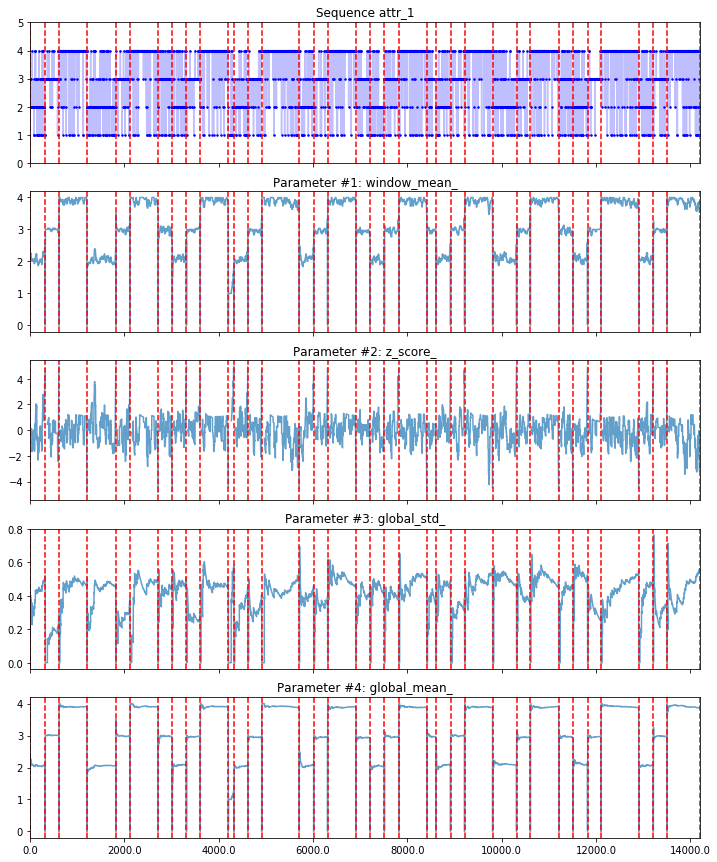

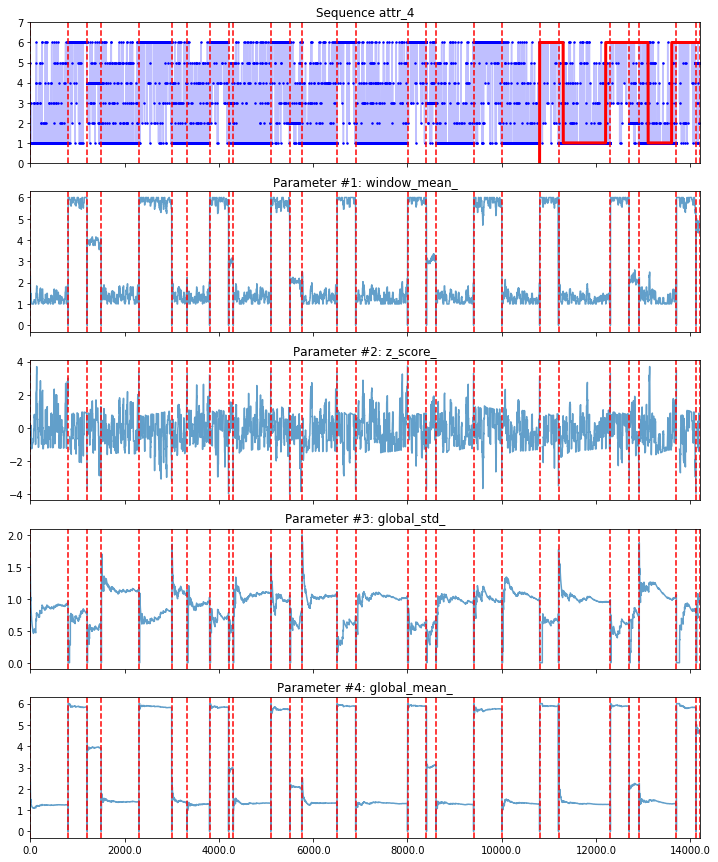

In [23]:
start_time = time.time()

simulator.run(plot=True, detect_rules=True, predict_seq=True)

#print_detected_change_points(simulator.get_detected_changes())
#print_rules(simulator.get_rules_sets(), 0)

end_time = time.time()
print(end_time - start_time)

plt.show()

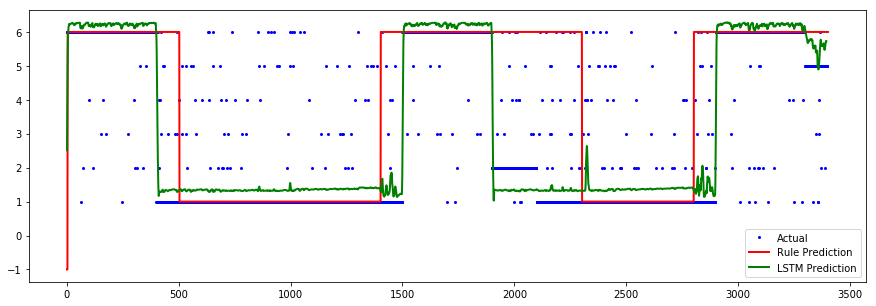

In [30]:
#import matplotlib.pyplot as plt2
plt.rcParams['figure.figsize'] = [15, 5]

plt.plot(sequences[1][10800:], 'b.', markersize=4, label="Actual")
#plt.plot(sequences[1][10800:], 'b-', alpha=0.1)
#for change_point in simulator.detected_change_points[1]:
#    plt2.axvline(change_point.at_, color='r', linestyle='--')

plt.plot(simulator.predictor.predicted[10800:], 'r', linewidth=2.0, label='Rule Prediction')
plt.plot(newp[150:], color='g',linewidth=2.0, label='LSTM Prediction')
#plt.xticks(np.arange(0, len(sequences[3]), 500))


plt.legend(loc='best')
plt.savefig('test.eps', format='eps', dpi=1000)
plt.show()


In [34]:
pr = int(len(sequences[1])*predict_ratio) + 20

predicted = simulator.predictor.predicted[10803:]
real = sequences[1][10800:] #sp.signal.medfilt(sequences[1][pr:],21)

rmse = np.sqrt(((predicted - real) ** 2).mean())
print('Mean Squared Error Rules: {}'.format(round(rmse, 5)))

rmse = np.sqrt(((newp[150:] - real) ** 2).mean())
print('Mean Squared Error LSTM: {}'.format(round(rmse, 5)))

Mean Squared Error Rules: 2.20547
Mean Squared Error LSTM: 3.30229


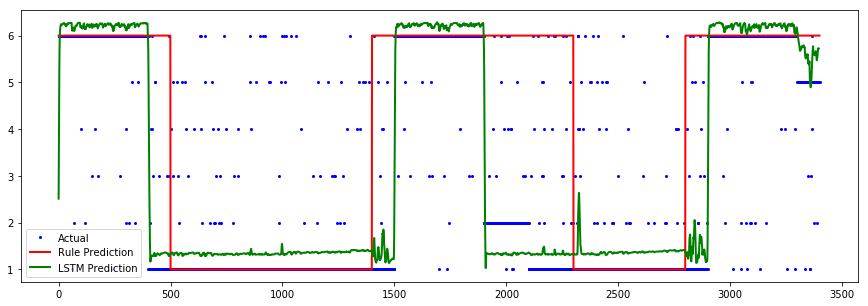

Mean Squared Error Rules: 2.20547
Mean Squared Error LSTM: 3.30229


In [38]:
predicted = simulator.predictor.predicted[10803:]
predicted_lstm = newp[150:]
real = sequences[1][10800:]

plt.rcParams['figure.figsize'] = [15, 5]

plt.plot(real, 'b.', markersize=4, label="Actual")
#plt.plot(sequences[1][10800:], 'b-', alpha=0.1)
#for change_point in simulator.detected_change_points[1]:
#    plt2.axvline(change_point.at_, color='r', linestyle='--')

plt.plot(predicted, 'r', linewidth=2.0, label='Rule Prediction')
plt.plot(predicted_lstm, color='g',linewidth=2.0, label='LSTM Prediction')
#plt.xticks(np.arange(0, len(sequences[3]), 500))


plt.legend(loc='best')
plt.savefig('test.eps', format='eps', dpi=1000)
plt.show()

rmse_rules = np.sqrt(((predicted - real) ** 2).mean())
print('Mean Squared Error Rules: {}'.format(round(rmse_rules, 5)))

rmse_lstm = np.sqrt(((predicted_lstm - real) ** 2).mean())
print('Mean Squared Error LSTM: {}'.format(round(rmse_lstm, 5)))